## 01-Diagnosing negative divergence in ridges and negative convergence in trenches

This notebook uses the script `diagnose_convergence.py` to identify ridge segments with negative divergence (convergence) and trench segments with negative convergence (divergence). Negative divergence are positive velocities, while negative convergence are negative velocities. 

In [1]:
from diagnose_convergence import diagnose_topology_convergence

import numpy as np
import pygplates
import ptt
import gplately

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader

import os, glob
import pandas as pd

### Loading files (1): GPlately's DataServer
Plate models available: `Muller2019`, `Muller2016`, `Cao2020`, `Clennett2020`, `Seton2012`, `Matthews2016`, `Meridth2017`, `Li2008`, `Pehrsson2015`, `TorsvikCocks2017`, `Young2019`, `Scotese2008`, `Golonka2007`, `Clennett2020_M2019`, `Clennett2020_S2013`

In [2]:
# Point to Merdith 2021 from DataServer
gdownload = gplately.download.DataServer("Merdith2021")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

coastlines, continents, COBs = gdownload.get_topology_geometries()
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continent-ocean boundaries in Merdith2021.


### Loading files (2): Pointing to filenames with glob, os
Remove """ """ to un-comment out these lines.

In [ ]:
"""
input_directory = "/Users/laurenilano/Downloads/SM2/"

# Rotation files and model
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)


# Topology feature filenames, and create a FeatureCollection
topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

static_polygons = pygplates.FeatureCollection(input_directory+"shapes_static_polygons_Merdith_et_al.gpml")
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)


time = 0 # Can be any time, and can be updated later using gplot.time = time
continent_filename = "/Users/laurenilano/Downloads/SM2 5/shapes_continents_Merdith_et_al.gpml"
gplot = gplately.plot.PlotTopologies(model, time, _, continent_filename)
"""

### Identify negatively divergent ridges and negatively convergent trenches

For MORs: By providing the parameter `convergent_velocity_threshold_cms_yr = 0`, only orthogonal velocities above 0 cm/yr are returned (convergence only). Positive values indicate negative divergence. Removing the threshold gives all positive and negative ridge divergence velocities.

For trenches: By providing the parameter `divergent_velocity_threshold_cms_yr = 0`, only orthogonal velocities below 0 cm/yr are returned (divergence only). Negative values indicate negative convergence. Removing the threshold gives all positive and negative trench convergence velocities.

In [3]:
def plot_ridges_and_transforms(model, gplot, time, save_directory):

    # IDENTIFY CONVERGENT MID OCEAN RIDGES --------------------------------------------------------------------
    mor_convergent_features, mor_convergent_vels = diagnose_topology_convergence(
        rotation_model, topology_features, time,
        convergent_velocity_threshold_cms_yr=0, # All velocity values above 0 are returned (positive = convergence).
        boundary_feature_types=[pygplates.FeatureType.gpml_mid_ocean_ridge]
    )
    mor_all_convergence_vels = [vel for point_vel in mor_convergent_vels for vel in point_vel]
    mor_lons = []
    mor_lats = []

    for r in mor_convergent_features:
        for segment in r.get_all_geometries():
            mor_lats.extend(segment.to_lat_lon_array()[:,0])
            mor_lons.extend(segment.to_lat_lon_array()[:,1])

    # IDENTIFY DIVERGENT SUBDUCTION ZONES --------------------------------------------------------------------
    sz_convergent_features, sz_convergent_vels = diagnose_topology_convergence(
        rotation_model, topology_features, time,
        divergent_velocity_threshold_cms_yr=0, # All velocity values below 0 are returned (negative = divergence).
        boundary_feature_types=[pygplates.FeatureType.gpml_subduction_zone]
    )
    sz_all_convergence_vels = [vel for point_vel in sz_convergent_vels for vel in point_vel]
    sz_lons = []
    sz_lats = []

    for r in sz_convergent_features:
        for segment in r.get_all_geometries():
            sz_lats.extend(segment.to_lat_lon_array()[:,0])
            sz_lons.extend(segment.to_lat_lon_array()[:,1])
                
    # Set up plot --------------------------------------------------------------------
    fig = plt.figure(figsize=(18,14), dpi=100)
    ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 20), facecolor='grey')
    ax1.set_title("PTT topologies at {} Ma: Merdith 2021".format(time))
    
    # Plot with GPlately's PlotTopologies object ------------------------------------------------------------
    gplot.time = time
    gplot.plot_continents(ax1, color='darkgrey')
    gplot.plot_plate_motion_vectors(ax1, spacingX=7.5, spacingY=7.5, alpha=0.3, color='k', zorder=2)

    # Plot convergent MOR points using a diverging colormap ----------------------------------
    ridges = ax1.scatter(mor_lons, mor_lats, c=mor_all_convergence_vels, vmin=-20, vmax=20, 
                         cmap='seismic', s=50, transform=ccrs.PlateCarree(), label="gpml:mid_ocean_ridge")
    plt.colorbar(ridges, shrink=0.3, label="gpml:mid_ocean_ridge rate (cm/yr)")
    
    # Plot divergent trenches using a diverging colormap
    trenches = ax1.scatter(sz_lons, sz_lats, marker="*", transform=ccrs.PlateCarree(), 
                             c=sz_all_convergence_vels, cmap='seismic', vmax=20, vmin=-20,
                            label="gpml:subduction_zone features")
    plt.colorbar(trenches, shrink=0.3, label="gpml:subduction_zone rate (cm/yr)")
    
    ax1.legend(loc="lower left", bbox_to_anchor=(-0.1,-0.1))

    # Plate boundary outlines: -------------------------------------------------------------------
    # Identify all unique plate IDs belonging to each topology at this timestep
    plate_ids = []
    for feature in gplot.topologies:
        plate_ids.append(feature.get_reconstruction_plate_id())
    unique_plate_ids = np.unique(plate_ids)
    
    for plate_id in unique_plate_ids:
        gplot.plot_plate_id(ax1, plate_id, facecolor=(0, 1, 0, 0), edgecolor="k")
        
    ax1.set_global()
    plt.savefig(save_directory+"/negative_divergence_and_convergence_{}_Ma.png".format(int(time)))
    
    # plt.close() # (TOGGLE THIS TO MINIMISE PLOT OUTPUTS!!)
    
    print("Image for {} Ma done!".format(time))
    return mor_all_convergence_vels, sz_all_convergence_vels # To access the velocities


/Users/laurenilano/opt/miniconda3/envs/gplateely/lib/python3.8/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


Image for 500 Ma done!


/Users/laurenilano/opt/miniconda3/envs/gplateely/lib/python3.8/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


Image for 499 Ma done!


/Users/laurenilano/opt/miniconda3/envs/gplateely/lib/python3.8/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


Image for 498 Ma done!


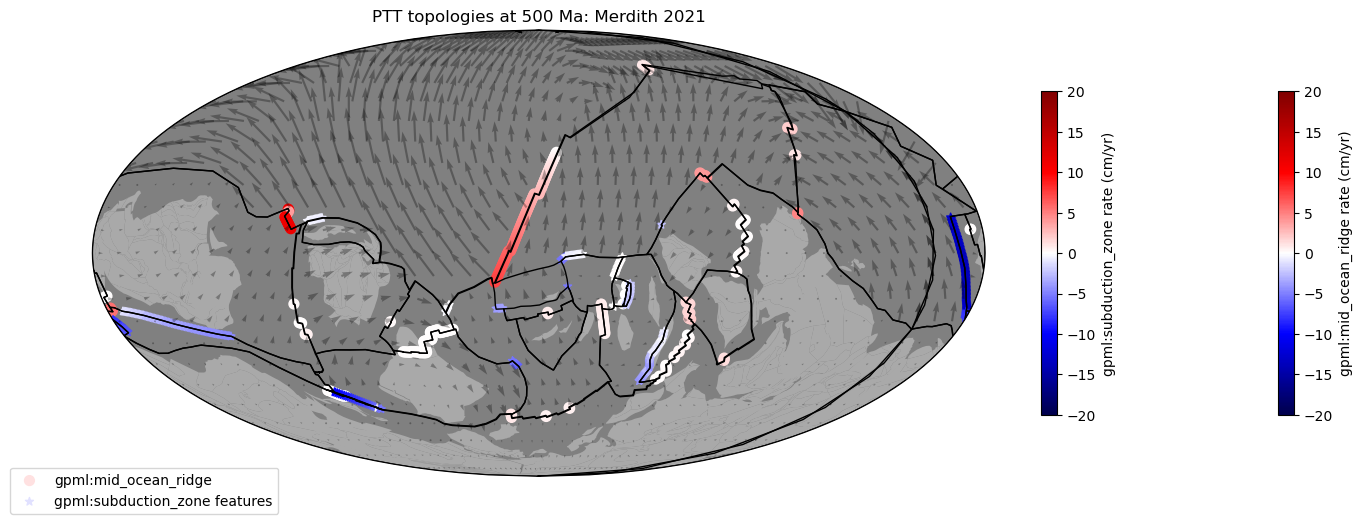

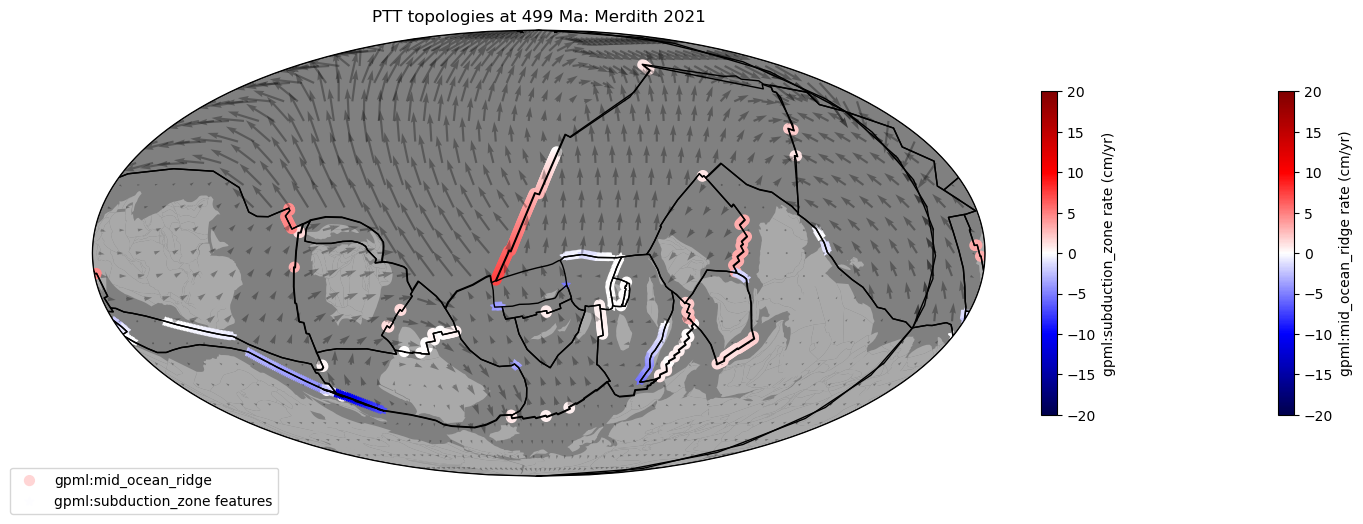

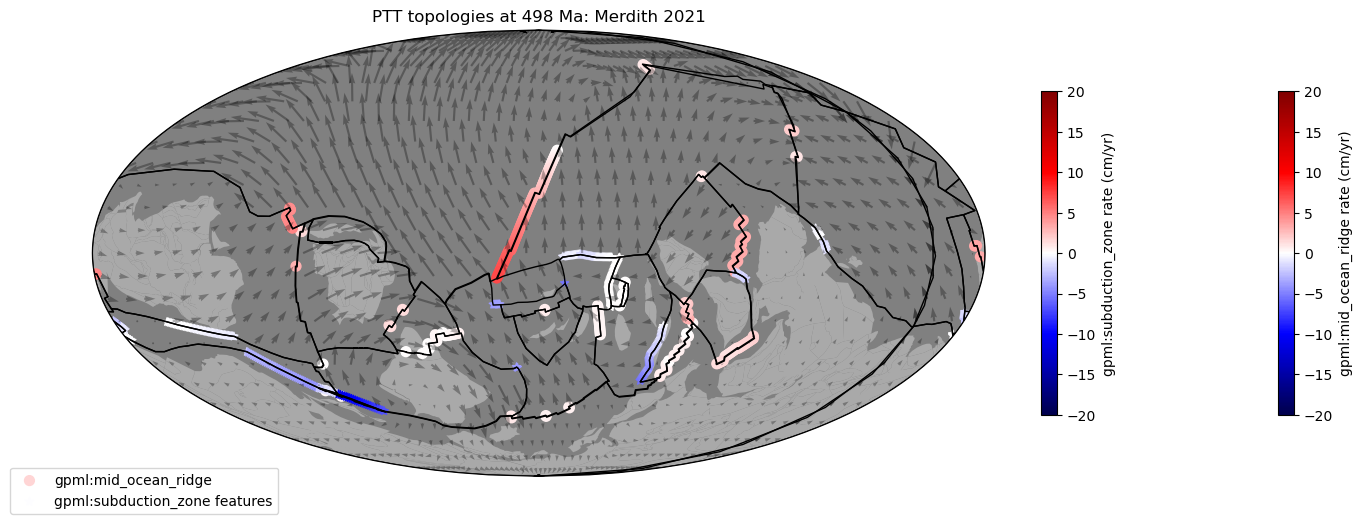

In [4]:
# Time variables
max_time = 500 # Ma
min_time = 498 # Ma
time_step = 1 # Ma
reconstruction_times = np.arange(min_time, max_time+time_step, time_step)[::-1]

save_directory = "./OutputFigures"
for time in reconstruction_times:
    mor_all_convergence_vels, sz_all_convergence_vels = plot_ridges_and_transforms(model, gplot, time, save_directory)

### Run this cell to make a movie and save to MP4

In [ ]:
import moviepy.editor as mpy
import numpy as np

frame_list = []

for time in np.arange(min_time, max_time+time_step, time_step)[::-1]:
    frame_list.append(save_directory+"/negative_divergence_and_convergence_{}_Ma.png".format(int(time)))
    
clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif(save_directory+"/negative_divergence_and_convergence.gif")

from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open(save_directory+"/negative_divergence_and_convergence.gif",'rb') as f:
    display(Image(data=f.read(), format='png', width = 2000, height = 500))
    
clip = mpy.VideoFileClip(save_directory+"/negative_divergence_and_convergence.gif")
clip.write_videofile(save_directory+"/negative_divergence_and_convergence.mp4")